# Tutorial from: https://deeplearning.neuromatch.io/tutorials/W2D5_AttentionAndTransformers/student/W2D5_Tutorial1.html

In [ ]:
# # @title Install dependencies
# # @markdown There may be *errors* and/or *warnings* reported during the installation. However, they are to be ignored.
# !pip install tensorboard --quiet
# !pip install transformers --quiet
# !pip install datasets --quiet
# !pip install pytorch_pretrained_bert --quiet
# !pip install torchtext --quiet
# !pip install --upgrade gensim --quiet

In [ ]:
# @title Install and import feedback gadget

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_dl",
            "user_key": "f379rz8y",
        },
    ).render()


feedback_prefix = "W2D5_T1"

In [ ]:
# @title Set environment variables

import os
os.environ['TA_CACHE_DIR'] = 'data/'
os.environ['NLTK_DATA'] = 'nltk_data/'

In [10]:
# Imports
import os
import sys
import math
import nltk
import torch
import random
import string
import datasets
import statistics

import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

from nltk.corpus import brown
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchtext.vocab import Vectors

from pprint import pprint
from tqdm.notebook import tqdm
from abc import ABC, abstractmethod

from pytorch_pretrained_bert import BertTokenizer
from pytorch_pretrained_bert import BertForMaskedLM

from transformers import AutoTokenizer

%load_ext tensorboard

In [12]:
# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [16]:
# @title Download NLTK data (`punkt`, `averaged_perceptron_tagger`, `brown`, `webtext`)


#NLTK Download:

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')
nltk.download('webtext')


import os, requests, zipfile

os.environ['NLTK_DATA'] = 'nltk_data/'

fname = 'nltk_data.zip'
url = 'https://osf.io/download/zqw5s/'

r = requests.get(url, allow_redirects=True)

with open(fname, 'wb') as fd:
  fd.write(r.content)

with zipfile.ZipFile(fname, 'r') as zip_ref:
  zip_ref.extractall('.')

[nltk_data] Downloading package punkt to /home/mekala/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/mekala/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package brown to /home/mekala/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package webtext to /home/mekala/nltk_data...
[nltk_data]   Unzipping corpora/webtext.zip.


In [17]:
# @title Helper functions
global category
global brown_wordlist
global w2vmodel
category = ['editorial', 'fiction', 'government', 'mystery', 'news',
                   'religion', 'reviews', 'romance', 'science_fiction']
brown_wordlist = list(brown.words(categories=category))

def create_word2vec_model(category = 'news', size = 50, sg = 1, min_count = 10):
    sentences = brown.sents(categories=category)
    model = Word2Vec(sentences, vector_size=size, sg=sg, min_count=min_count)
    return model

w2vmodel = create_word2vec_model(category)

def model_dictionary(model):
  print(w2vmodel.wv)
  words = list(w2vmodel.wv)
  return words

def get_embedding(word, model):
  try:
    return model.wv[word]
  except KeyError:
    print(f' |{word}| not in model dictionary. Try another word')

def check_word_in_corpus(word, model):
  try:
    word_embedding = model.wv[word]
    print('Word present!')
    return word_embedding
  except KeyError:
    print('Word NOT present!')
    return None

def get_embeddings(words,model):
  size = w2vmodel.layer1_size
  embed_list = [get_embedding(word,model) for word in words]
  return np.array(embed_list)

def softmax(x):
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x

In [18]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Handles variability by controlling sources of randomness
  through set seed values

  Args:
    seed: Integer
      Set the seed value to given integer.
      If no seed, set seed value to random integer in the range 2^32
    seed_torch: Bool
      Seeds the random number generator for all devices to
      offer some guarantees on reproducibility

  Returns:
    Nothing
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [19]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [20]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


## Load Yelp dataset

**Description**:

YELP dataset contains a subset of Yelp's businesses/reviews and user data.

    1,162,119 tips by 2,189,457 users
    Over 1.2 million business attributes like hours, parking, availability, and ambience
    Aggregated check-ins over time for each of the 138,876 businesses

Each file is composed of a single object type, one JSON-object per-line.
For detailed structure, see [here](https://www.yelp.com/dataset/documentation/main).

Each file is composed of a single object type, one JSON-object per-line. For detailed structure, see here(https://www.yelp.com/dataset/documentation/main).

In [21]:
# @title `load_yelp_data` helper function

def load_yelp_data(DATASET, tokenizer):
  """
  Load Train and Test sets from the YELP dataset.

  Args:
    DATASET: datasets.dataset_dict.DatasetDict
      Dataset dictionary object containing 'train' and 'test' sets of YELP reviews and sentiment classes
    tokenizer: Transformer autotokenizer object
      Downloaded vocabulary from bert-base-cased and cache.

  Returns:
    train_loader: Iterable
      Dataloader for the Training set with corresponding batch size
    test_loader: Iterable
      Dataloader for the Test set with corresponding batch size
    max_len: Integer
      Input sequence size
    vocab_size: Integer
      Size of the base vocabulary (without the added tokens).
    num_classes: Integer
      Number of sentiment class labels
  """
  dataset = DATASET
  dataset['train'] = dataset['train'].select(range(10000))
  dataset['test'] = dataset['test'].select(range(5000))
  dataset = dataset.map(lambda e: tokenizer(e['text'], truncation=True,
                                            padding='max_length'), batched=True)
  dataset.set_format(type='torch', columns=['input_ids', 'label'])

  train_loader = torch.utils.data.DataLoader(dataset['train'], batch_size=32)
  test_loader = torch.utils.data.DataLoader(dataset['test'], batch_size=32)

  vocab_size = tokenizer.vocab_size
  max_len = next(iter(train_loader))['input_ids'].shape[0]
  num_classes = next(iter(train_loader))['label'].shape[0]

  return train_loader, test_loader, max_len, vocab_size, num_classes

In [22]:
# @title Download and load the dataset

import requests, tarfile

os.environ['HF_DATASETS_CACHE'] = 'data/'

url = "https://osf.io/kthjg/download"
fname = "huggingface.tar.gz"

if not os.path.exists(fname):
  print('Dataset is being downloading...')
  r = requests.get(url, allow_redirects=True)
  with open(fname, 'wb') as fd:
    fd.write(r.content)
  print('Download is finished.')

  with tarfile.open(fname) as ft:
    ft.extractall('data/')
  print('Files have been extracted.')

DATASET = datasets.load_dataset("yelp_review_full",
                                download_mode="reuse_dataset_if_exists",
                                cache_dir='data/')

# If the above produces an error uncomment below:
# DATASET = load_dataset("yelp_review_full", ignore_verifications=True)
print(type(DATASET))

Dataset is being downloading...
Download is finished.
Files have been extracted.


Found cached dataset yelp_review_full (/home/mekala/jupyter_books/Transformers/data/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf)
100%|██████████| 2/2 [00:00<00:00, 529.65it/s]

<class 'datasets.dataset_dict.DatasetDict'>


In [23]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased', cache_dir='data/')
train_loader, test_loader, max_len, vocab_size, num_classes = load_yelp_data(DATASET, tokenizer)

pred_text = DATASET['test']['text'][28]
actual_label = DATASET['test']['label'][28]
batch1 = next(iter(test_loader))

In [24]:
# @title Helper functions for BERT infilling

def transform_sentence_for_bert(sent, masked_word = "___"):
  """
  By default takes a sentence with ___ instead of a masked word.

  Args:
    sent: String
      An input sentence
    masked_word: String
      Masked part of the sentence

  Returns:
    str: String
      Sentence that could be mapped to BERT
  """
  splitted = sent.split("___")
  assert (len(splitted) == 2), "Missing masked word. Make sure to mark it as ___"

  return '[CLS] ' + splitted[0] + "[MASK]" + splitted[1] + ' [SEP]'


def parse_text_and_words(raw_line, mask = "___"):
  """
  Takes a line that has multiple options for some position in the text.

  Usage/Example:
    Input: The doctor picked up his/her bag
    Output: (The doctor picked up ___ bag, ['his', 'her'])

  Args:
    raw_line: String
      A line aligning with format - 'some text option1/.../optionN some text'
    mask: String
      The replacement for .../... section

  Returns:
    str: String
      Text with mask instead of .../... section
    list: List
      List of words from the .../... section
  """
  splitted = raw_line.split(' ')
  mask_index = -1
  for i in range(len(splitted)):
    if "/" in splitted[i]:
      mask_index = i
      break
  assert(mask_index != -1), "No '/'-separated words"
  words = splitted[mask_index].split('/')
  splitted[mask_index] = mask
  return " ".join(splitted), words


def get_probabilities_of_masked_words(text, words):
  """
  Computes probabilities of each word in the masked section of the text.

  Args:
    text: String
      A sentence with ___ instead of a masked word.
    words: List
      Array of words.

  Returns:
    list: List
      Predicted probabilities for given words.
  """
  text = transform_sentence_for_bert(text)
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  for i in range(len(words)):
    words[i] = tokenizer.tokenize(words[i])[0]
  words_idx = [tokenizer.convert_tokens_to_ids([word]) for word in words]
  tokenized_text = tokenizer.tokenize(text)
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  masked_index = tokenized_text.index('[MASK]')
  tokens_tensor = torch.tensor([indexed_tokens])

  pretrained_masked_model = BertForMaskedLM.from_pretrained('bert-base-uncased')
  pretrained_masked_model.eval()

  # Predict all tokens
  with torch.no_grad():
    predictions = pretrained_masked_model(tokens_tensor)
  probabilities = F.softmax(predictions[0][masked_index], dim = 0)
  predicted_index = torch.argmax(probabilities).item()

  return [probabilities[ix].item() for ix in words_idx]

Video available at https://youtube.com/watch?v=UnuSQeT8GqQ


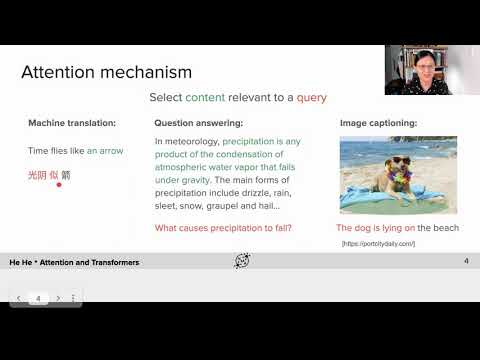

Video available at https://www.bilibili.com/video/BV1hf4y1j7XE


In [25]:
# @title Video 1: Introduction
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'UnuSQeT8GqQ'), ('Bilibili', 'BV1hf4y1j7XE')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [26]:
# # @title Submit your feedback
# content_review(f"{feedback_prefix}_Introduction_Video")

NameError: name 'content_review' is not defined